In [ ]:
# Install the 'opendatasets' package using pip.
!pip install opendatasets
# Import the installed 'opendatasets' package and use the alias 'od' for convenience.
import opendatasets as od


In [ ]:
# Use the 'download' function from the 'opendatasets' package to download a dataset from the specified URL.
od.download('https://www.kaggle.com/datasets/obulisainaren/multi-cancer')

Skipping, found downloaded files in "./multi-cancer" (use force=True to force download)


In [ ]:
# Define file paths for the training, testing, and validation datasets within the 'multi-cancer' directory.
train_set = "/content/multi-cancer/Multi Cancer/ALL"
test_set = "/content/multi-cancer/Multi Cancer/ALL"
validation_set = "/content/multi-cancer/Multi Cancer/ALL"


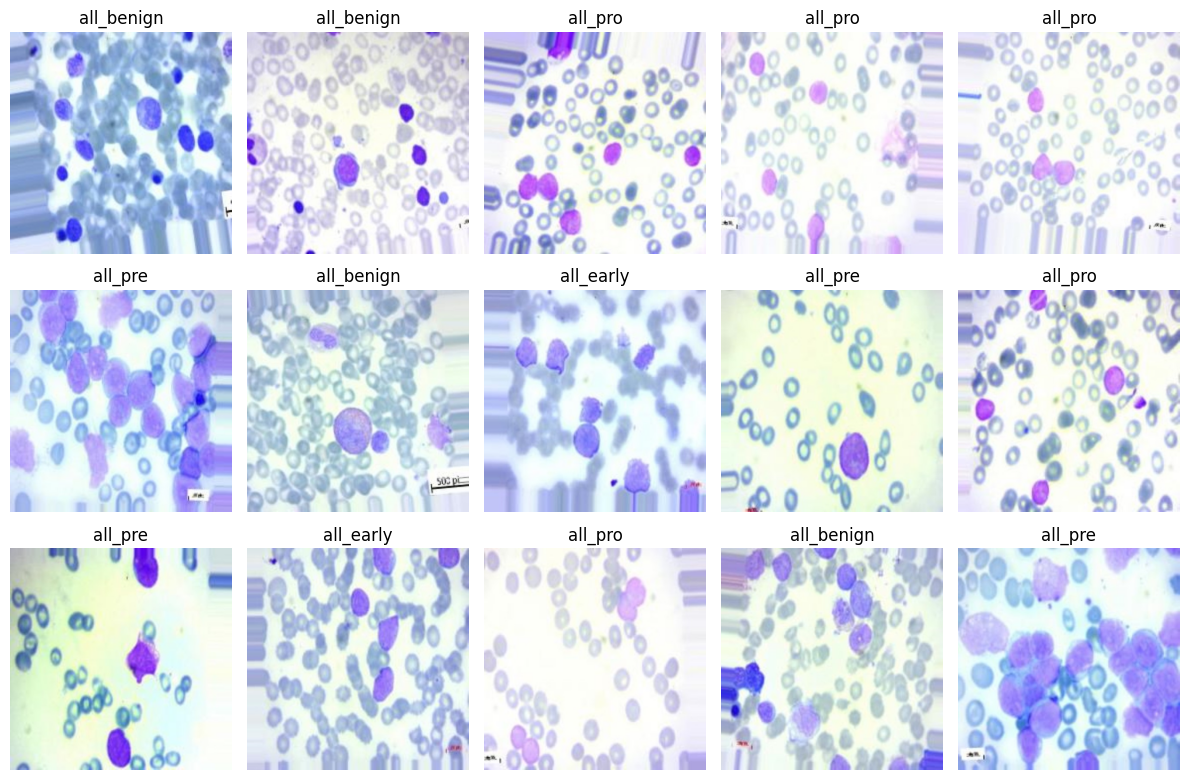

In [ ]:
#To visualize a random selection of 15 images from a specified directory in a 3x5 grid format. Each image is displayed in a subplot, and the subfolder name from which the image was sourced is used as the subplot title.

import matplotlib.pyplot as plt
import numpy as np
import glob
import os

# Specify the path to your image directory
image_dir = train_set

# Retrieve all image paths recursively from the directory
image_paths = glob.glob(image_dir + '/**/*.jpg', recursive=True)

# Select a subset of images to display
num_images = 15
selected_images = np.random.choice(image_paths, num_images, replace=False)
# Create a grid plot to display the images
rows = 3  # Number of rows in the grid
cols = 5  # Number of columns in the grid
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

# Iterate over the selected images and display them on the grid
for i, image_path in enumerate(selected_images):
    row = i // cols
    col = i % cols
    img = plt.imread(image_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

    # Extract the subfolder name from the image path
    subfolder = os.path.basename(os.path.dirname(image_path))

    # Set the subfolder name as the subplot title
    axes[row, col].set_title(subfolder)

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()


In [ ]:
#These components are essential for building and training deep learning models for image recognition ,data augmentation and classification.
from keras.preprocessing.image import ImageDataGenerator

# Import the TensorFlow library and alias it as 'tf'.
import tensorflow as tf

# Import the MobileNet model and the preprocess_input function from the keras.applications.mobilenet module.
from keras.applications.mobilenet import MobileNet, preprocess_input



In [ ]:
# Create an instance of the ImageDataGenerator class with various data augmentation and preprocessing configurations.
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to the range [0, 1] for standardization.
    rotation_range=40,  # Randomly rotate images by up to 40 degrees.
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the total width.
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the total height.
    shear_range=0.2,  # Apply shear transformations.
    zoom_range=0.2,  # Randomly zoom in on images by up to 20%.
    horizontal_flip=True,  # Randomly flip images horizontally.
    fill_mode='nearest',  # Strategy for filling in newly created pixels, used in image transformations.
    validation_split=0.2  # Fraction of the data to reserve for validation. (20% in this case)
)



In [ ]:
# Generate augmented training data batches using the previously configured datagen from the specified directory.
train_data = datagen.flow_from_directory(
    train_set,  # Directory path containing the training images.
    target_size=(224, 224),  # Resizes images to a fixed size of 224x224 pixels.
    batch_size=256,  # Number of images in each batch of data.
    class_mode='categorical',  # Type of label encoding for the classes (categorical for one-hot encoding).
    subset='training'  # Specifies that this data is meant for training (utilizing the training subset).
)

# Generate augmented validation data batches using the same datagen configuration from the same directory.
val_data = datagen.flow_from_directory(
    train_set,  # Directory path containing the training images (same as the training set).
    target_size=(224, 224),  # Resizes images to a fixed size of 224x224 pixels.
    batch_size=256,  # Number of images in each batch of data.
    class_mode='categorical',  # Type of label encoding for the classes (categorical for one-hot encoding).
    subset='validation'  # Specifies that this data is meant for validation (utilizing the validation subset).
)


Found 16000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


In [ ]:
# Print the class indices for the training and validation datasets.
print(train_data.class_indices)
print(val_data.class_indices)

{'all_benign': 0, 'all_early': 1, 'all_pre': 2, 'all_pro': 3}
{'all_benign': 0, 'all_early': 1, 'all_pre': 2, 'all_pro': 3}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

# Define the input shape of your images (e.g., 224x224 pixels for VGG19)
input_shape = (224, 224, 3)

# Create a VGG19 base model (pre-trained on ImageNet)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG19 base
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # Replace num_classes with the number of classes in your dataset
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 26480580 (101.02 MB)
Trainable params: 6456196 (24.63 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
model.fit(train_data, epochs= 10, validation_data=val_data, workers=8, use_multiprocessing=True, batch_size = 64)

Epoch 1/10
63/63 [==============================] - 476s 6s/step - loss: 0.4259 - accuracy: 0.8519 - val_loss: 0.1996 - val_accuracy: 0.9390
Epoch 2/10
63/63 [==============================] - 395s 6s/step - loss: 0.1494 - accuracy: 0.9517 - val_loss: 0.1210 - val_accuracy: 0.9622
Epoch 3/10
63/63 [==============================] - 389s 6s/step - loss: 0.1010 - accuracy: 0.9703 - val_loss: 0.0920 - val_accuracy: 0.9732
Epoch 4/10
63/63 [==============================] - 389s 6s/step - loss: 0.0841 - accuracy: 0.9752 - val_loss: 0.0784 - val_accuracy: 0.9768
Epoch 5/10
63/63 [==============================] - 422s 6s/step - loss: 0.0731 - accuracy: 0.9772 - val_loss: 0.0707 - val_accuracy: 0.9780
Epoch 6/10
63/63 [==============================] - 434s 6s/step - loss: 0.0688 - accuracy: 0.9779 - val_loss: 0.0648 - val_accuracy: 0.9805
Epoch 7/10
63/63 [==============================] - 450s 6s/step - loss: 0.0584 - accuracy: 0.9809 - val_loss: 0.0572 - val_accuracy: 0.9812
Epoch 8/10
63

In [ ]:
# Save the trained model to a file named 'all.h5'.
model.save('all.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 64s 4s/step


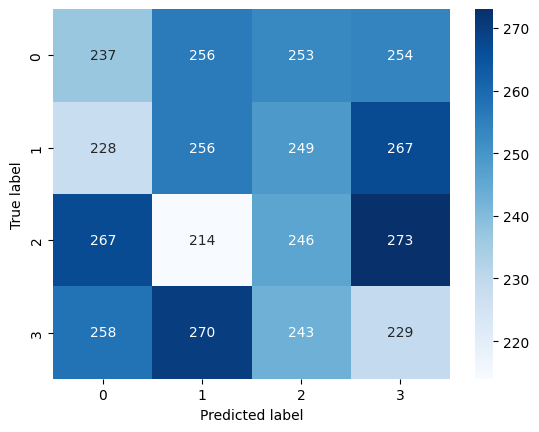

In [ ]:
# Generate predictions for the validation dataset using the trained model.
predictions = model.predict(val_data)

# Extract predicted labels by finding the indices of the highest probability in each prediction array.
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation data generator.
true_labels = val_data.classes

# Import the 'confusion_matrix' function from sklearn.metrics to create a confusion matrix.
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix to visualize the model's performance.
cm = confusion_matrix(true_labels, predicted_labels)

# Import necessary libraries for visualization: matplotlib and seaborn.
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix as a heatmap with annotations.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
# Generate predictions for the validation dataset using the trained model.
predictions = model.predict(val_data)

# Extract predicted labels by finding the indices of the highest probability in each prediction array.
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation data generator.
true_labels = val_data.classes

# Import the 'classification_report' function from sklearn.metrics to generate a classification report.
from sklearn.metrics import classification_report

# Generate a classification report comparing true labels with predicted labels.
# 'target_names' parameter maps numerical class indices to their corresponding class names.
report = classification_report(true_labels, predicted_labels, target_names=val_data.class_indices.keys())

# Print the classification report to evaluate the model's performance.
print(report)



16/16 [==============================] - 62s 4s/step
              precision    recall  f1-score   support

  all_benign       0.26      0.26      0.26      1000
   all_early       0.25      0.26      0.25      1000
     all_pre       0.24      0.24      0.24      1000
     all_pro       0.26      0.26      0.26      1000

    accuracy                           0.26      4000
   macro avg       0.26      0.26      0.25      4000
weighted avg       0.26      0.26      0.25      4000



In [ ]:

img='/content/multi-cancer/Multi Cancer/ALL/all_pre/all_pre_0002.jpg'

In [ ]:
import cv2

In [ ]:
#Defines a function called predict_disease that takes a test image file path as input,
#preprocesses the image, makes predictions using the trained model, and returns the predicted class label.
def predict_disease(test_image):
    # Read the image using OpenCV and normalize pixel values to the range [0, 1].
    img = cv2.imread(test_image)
    img = img / 255.0

    # Resize the image to match the input size expected by the model (224x224 pixels).
    img = cv2.resize(img, (224, 224))

    # Reshape the image to match the input shape expected by the model (1 sample, 224x224 pixels, 3 channels).
    img = img.reshape(1, 224, 224, 3)

    # Make predictions for the processed image using the trained model.
    prediction = model.predict(img)

    # Find the class with the highest probability as the predicted class.
    pred_class = np.argmax(prediction, axis=-1)

    # Return the predicted class.
    return pred_class


In [ ]:
# Make predictions for the example image using the 'predict_disease' function.
pred = predict_disease(img)

# Extract the predicted disease class index from the prediction result.
d = pred[0]


1/1 [==============================] - 0s 24ms/step


In [ ]:
# List containing class labels corresponding to disease categories.
lis = ['acute_lymphoblastic_leukemia_benign', 'acute_lymphoblastic_leukemia_early', 'acute_lymphoblastic_leukemia_pre', 'acute_lymphoblastic_leukemia_pro']

In [ ]:
# Print the detected disease stage based on the predicted class index.
print(f'The detected stage is {lis[d]}')


The detected stage is pre
